# DeepLense projects - Common Test 1 - Multi-Class Classification

## Imports and Configs

In [24]:
# Imports
from collections import Counter
from functools import partial
from pathlib import Path

# Importing self-defined functions and classes from another notebook
from Modules.NbLoader import *

FUNC_CLASSES_PATH = Path.cwd() / "Modules" / "Functions-Classes.ipynb"
functions_classes = NotebookLoader(path=FUNC_CLASSES_PATH).load_module(
    "functions_classes"
)

import torch
from functions_classes import *
from joblib import dump, load
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from torchvision.transforms import Normalize

importing Jupyter notebook from /home2/nouduru.venkata/GSOC/NVR-ML4SCI-GSOC24/DeepLense Tests/Codes/Modules/Functions-Classes.ipynb


In [25]:
# Configs
LABEL_MAP = {"vort": 0, "sphere": 1, "no": 2}

# Save bools
SAVE_METRICS: bool = False
SAVE_MODELS: bool = False
SAVE_PLOTS: bool = False

# Data Configs
SCALE_OUTPUTS: bool = False
BATCH_SIZE: int = 128
SHUFFLE_LOADING: bool = True

# Training Configs
N_EPOCHS = 25

# Torch configs
torch.set_default_dtype(torch.float64)

## Data Loading and Exploration

In [26]:
# Defining relative paths
CWD = Path.cwd()
DATA_FOLDER = CWD.parent / "Datasets" / "ct1"
OUTPUTS = CWD.parent / "Outputs" / "ct1"

OUTPUTS.mkdir(parents=True, exist_ok=True)

# Loading paths
LOAD_MODELS = Path.cwd()
LOAD_WEIGHTS = Path.cwd()

In [27]:
# Sorting file paths into train and val files
ALL_FILES = list(DATA_FOLDER.rglob("*.npy"))
TRAIN_FILES = list(filter(lambda x: x.parents[1].name == "train", ALL_FILES))
VAL_FILES = list(filter(lambda x: x.parents[1].name == "val", ALL_FILES))

In [28]:
# Defining DataLoaders using custom dataset class
transform = Normalize(0, 1)
trainset = CT1Set(
    file_paths=TRAIN_FILES,
    label_map=LABEL_MAP,
    transform=transform,
    target_transform=None,
)
valset = CT1Set(
    file_paths=VAL_FILES,
    label_map=LABEL_MAP,
    transform=transform,
    target_transform=None,
)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_LOADING)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_LOADING)

In [29]:
# Data Statistics
classes = list(LABEL_MAP.keys())
train_names = list(map(lambda x: x.parent.name, TRAIN_FILES))
val_names = list(map(lambda x: x.parent.name, VAL_FILES))

train_counts = Counter(train_names)
val_counts = Counter(val_names)

print(
    "".join(["="] * 20) + " Dataset statistics for Common Test 1 " + "".join(["="] * 20)
)
print("Distribution of Train images:")
print(train_counts)
print("\n")
print("Distribution of Validation (Test) images:")
print(val_counts)

==================== Dataset statistics for Common Test 1 ====================
Distribution of Train images:
Counter({'vort': 10000, 'no': 10000, 'sphere': 10000})


Distribution of Validation (Test) images:
Counter({'vort': 2500, 'no': 2500, 'sphere': 2500})


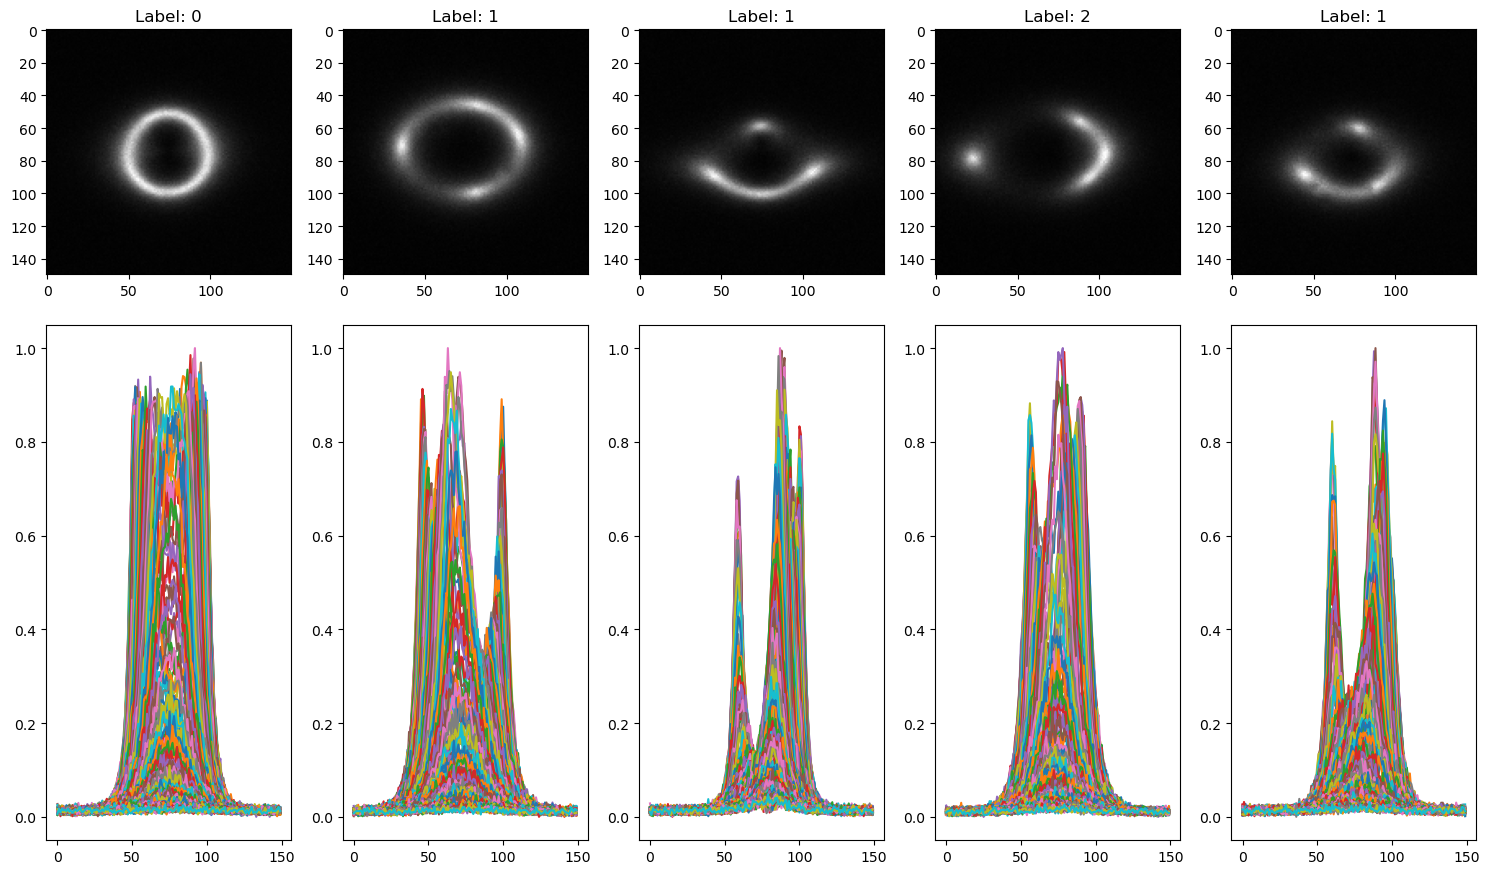

In [30]:
# Displaying random images from train data
random_plots(trainset)

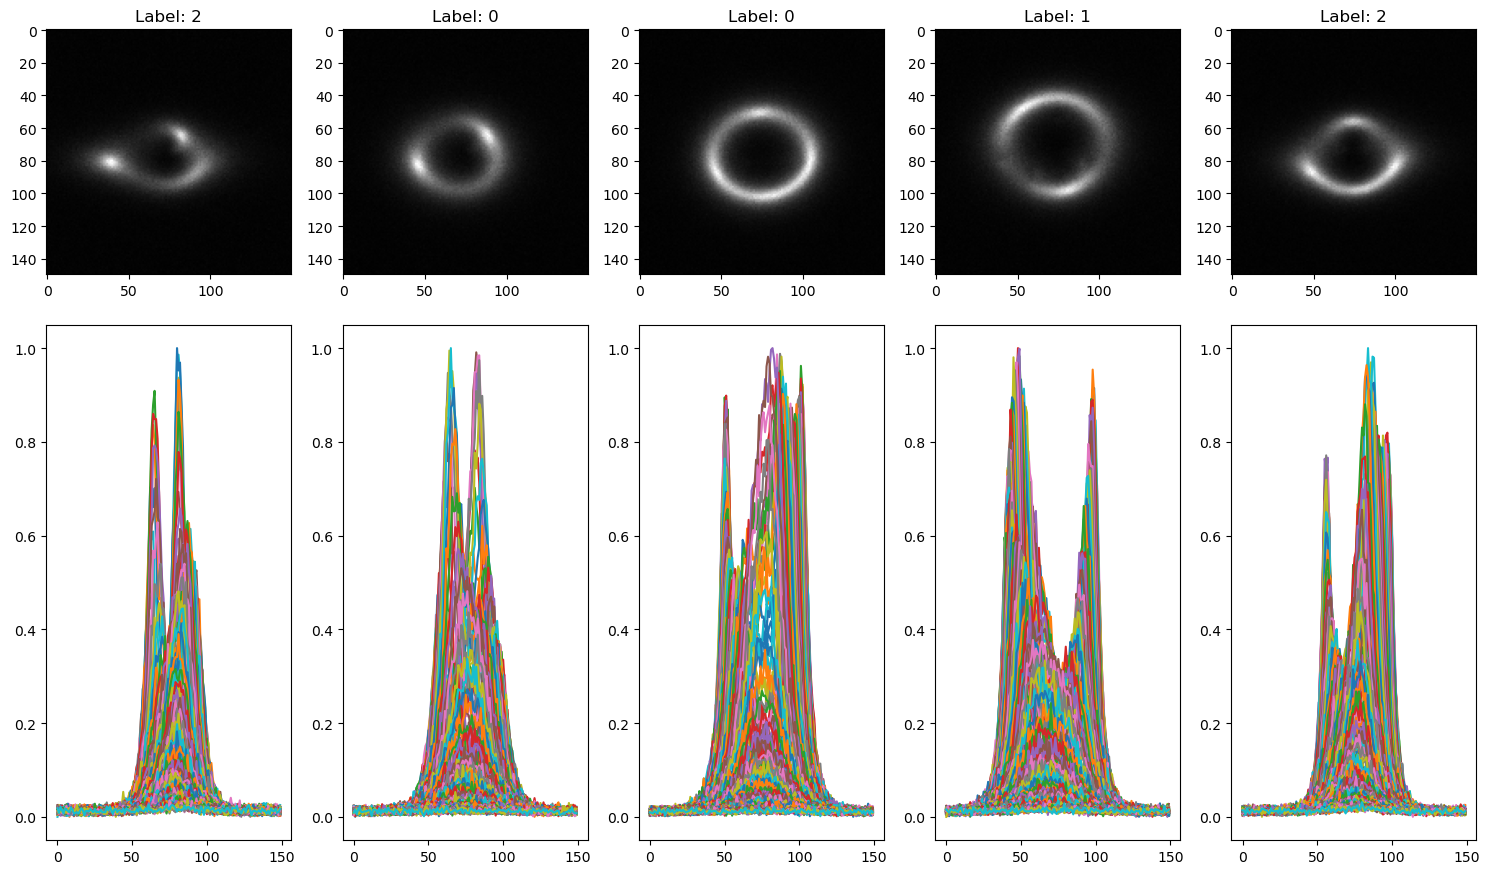

In [31]:
# Displaying random images from val data
random_plots(valset)

## Model Training and Testing

In [32]:
# Model Class definitions


# CNN 1
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 3),
        )

    def forward(self, x):
        out = self.model(x)
        return out


# Preparing ResNet 18 from PyTorch
resnet = torch.hub.load("pytorch/vision:v0.10.0", "resnet18", pretrained=True)


class mod_resnet(nn.Module):
    def __init__(self, pre_trained_resnet):
        super().__init__()
        self.cn1 = nn.Conv2d(1, 3, 5, 1, 2)
        self.pre_trained = pre_trained_resnet
        self.fc_last = nn.Linear(pre_trained_resnet.fc.out_features, 3)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.cn1(x)
        x = self.pre_trained(x)
        out = self.fc_last(x)
        # out = self.softmax(out)
        return out


# Metrics dictionary
metrics_dict = {
    "f1_score": metrics.f1_score,
    "accuracy": metrics.accuracy_score,
    "precision": metrics.precision_score,
    "recall": metrics.recall_score,
}

metric_args = {
    "f1_score": {"average": "macro"},
    "accuracy": None,
    "precision": {"average": "macro"},
    "recall": {"average": "macro"},
}

metrics_dict_partials = {
    sname: (partial(score, **metric_args[sname]) if metric_args[sname] else score)
    for sname, score in metrics_dict.items()
}

Using cache found in /home2/nouduru.venkata/.cache/torch/hub/pytorch_vision_v0.10.0
/home2/nouduru.venkata/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home2/nouduru.venkata/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Training models

# CNN
# model = CNN1()
model = mod_resnet(resnet)

# Model prep - For resnet only
for name, param in model.named_parameters():
    if ("fc" in name) or ("cn1" in name):
        param.requires_grad = True
    else:
        param.requires_grad = False

model_optim = optim(model)
criterion = nn.CrossEntropyLoss()

trained_model, train_loss, _ = modeltrainer(
    model,
    optimizer=model_optim,
    trainloader=trainloader,
    epochs=N_EPOCHS,
    criterion=criterion,
)

# Saving state dict
# torch.save(model.state_dict(), OUTPUTS / f"CNN1_{N_EPOCHS}eps.pth")
torch.save(model.state_dict(), OUTPUTS / f"ResNet18_{N_EPOCHS}eps.pth")
# dump(train_loss, OUTPUTS / f"CNN1_trainloss_{N_EPOCHS}eps.joblib")
dump(train_loss, OUTPUTS / f"ResNet18_trainloss_{N_EPOCHS}eps.joblib")

# Temporary joblib based saving
# dump(trained_model, "trained_cnn1_75ep.joblib")

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch finished in 00:09:32


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch finished in 00:08:20


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch finished in 00:09:05


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch finished in 00:08:01


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch finished in 00:07:58


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch finished in 00:07:58


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch finished in 00:08:02


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch finished in 00:08:31


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch finished in 00:08:24


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch finished in 00:08:05


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch finished in 00:08:30


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch finished in 00:09:30


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch finished in 00:09:52


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch finished in 00:07:56


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch finished in 00:08:03


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch finished in 00:08:29


  0%|          | 0/235 [00:00<?, ?it/s]

In [ ]:
# Plotting loss vs Number of Epochs
plt.plot(range(N_EPOCHS), train_loss)
plt.title("Train Loss vs Num_Epochs")
plt.ylabel("Train Loss")
plt.xlabel("Num_Epochs")
plt.show()

In [ ]:
# Loading models
# model = CNN1()
# model = mod
# model.load_state_dict(torch.load(OUTPUTS / f"CNN1_{N_EPOCHS}eps.pth"))
# train_loss = load("cnn1_trainloss_75ep.joblib")

# Temporary Joblib loading
# trained_model = load("trained_cnn1_75ep.joblib")

In [ ]:
# Testing models
# trained_models = {"CNN1": (model, train_loss)}
trained_models = {"ResNet18": (model, train_loss)}
metrictester(
    pt_trained=trained_models,
    metric_dict=metrics_dict_partials,
    ROC_AUC=False,
    testloader=valloader,
    multi_class=True,
    last_activation=nn.Softmax(dim=1),
    save_metrics=SAVE_METRICS,
    save_path=OUTPUTS,
    save_name="CT1 - ResNet18",
)